In [1]:
import os
from multiprocessing import cpu_count
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import wandb
from cutmix.cutmix import CutMix
from cutmix.utils import CutMixCrossEntropyLoss
from efficientnet_pytorch import EfficientNet
from layer.mish import Mish
from layer.rademacher_dropout import RademacherDropout
from optim.lookahead import Lookahead
from optim.radam import RAdam
from optim.ralamb import Ralamb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from torch import nn, optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision import models, transforms
from tqdm.auto import tqdm, trange
from trainer import Trainer

from dataset.affectnet import AffectNetDataset
from dataset.facialexpressions import FacialExpressionsDataset
from dataset.ferplus import FERPlusDataset
from dataset.rafdb import RAFDataset

In [2]:
pl.seed_everything(42)
torch.multiprocessing.set_sharing_strategy("file_system")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
resize_transform = transforms.Resize(224)
centercrop_transform = transforms.CenterCrop(224)
tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose(
    [
        resize_transform,
        centercrop_transform,
        transforms.RandomHorizontalFlip(),
        tensor_transform,
        normalize_transform,
    ]
)
predict_transform = transforms.Compose(
    [
        resize_transform,
        centercrop_transform,
        tensor_transform,
        normalize_transform,
    ]
)

In [5]:
trainset = ConcatDataset(
    [
        AffectNetDataset("../dataset/AffectNet", "train", transform=train_transform),
        FacialExpressionsDataset(
            "../dataset/facial_expressions", transform=train_transform
        ),
        FERPlusDataset("../dataset/FERPlus", "train", transform=train_transform),
        RAFDataset("../dataset/RAF-DB", "train", transform=train_transform),
    ]
)
len(trainset)

342497

In [6]:
classes = [
    "neutral",
    "happy",
    "surprise",
    "sad",
    "anger",
    "disgust",
    "fear",
    "contempt",
]
classes

['neutral', 'happy', 'surprise', 'sad', 'anger', 'disgust', 'fear', 'contempt']

In [7]:
n_samples = np.zeros(len(classes), dtype=int)

for innerset in trainset.datasets:
    for label in innerset.get_labels():
        n_samples[label] += 1

n_samples

array([ 94645, 152606,  19305,  31289,  28417,   4919,   7389,   3927])

In [8]:
normed_weights = [1 - (x / sum(n_samples)) for x in n_samples]
normed_weights = torch.FloatTensor(normed_weights).to(device)

In [9]:
# trainset = CutMix(trainset, num_class=len(classes), beta=1.0, prob=0.5, num_mix=2)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=cpu_count())
trainloader_not_shuffled = DataLoader(
    trainset, batch_size=32, shuffle=False, num_workers=cpu_count()
)

In [10]:
def show_dataset(dataset, n=5):
    pil_transform = transforms.ToPILImage()
    img = np.vstack(
        np.hstack([pil_transform(dataset[i][0]) for _ in range(5)])
        for i in [randint(0, len(dataset)) for _ in range(n)]
    )
    plt.imshow(img)

<ipython-input-10-acce69bc3967>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  img = np.vstack(


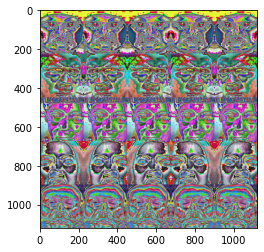

In [11]:
show_dataset(trainset)

In [12]:
valtestset = ConcatDataset(
    [
        AffectNetDataset("../dataset/AffectNet", "val", transform=predict_transform),
        FERPlusDataset("../dataset/FERPlus", "val", transform=predict_transform),
        FERPlusDataset("../dataset/FERPlus", "test", transform=predict_transform),
        RAFDataset("../dataset/RAF-DB", "test", transform=predict_transform),
    ]
)
valsize = int(len(valtestset) / 2)
valset, testset = random_split(valtestset, [valsize, int(len(valtestset) - valsize)])

valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=cpu_count())
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=cpu_count())
random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
len(valset), len(testset)

(7084, 7084)

In [13]:
GRAD_ACCS = 2
MAX_STEPS = 10000

In [14]:
class FacialExpressionsClassifier(pl.LightningModule):
    def __init__(self, classes, lr=0.01, max_steps=1000):
        super().__init__()
        # property init
        self.classes = classes
        self.lr = lr
        self.max_steps = max_steps
        self.criterion = nn.CrossEntropyLoss(weight=normed_weights)
        # self.criterion = CutMixCrossEntropyLoss(True)

        # model init
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, len(classes))

    def forward(self, x):
        return self.base_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.TrainResult(minimize=loss)
        result.log("train_loss", loss)
        return result

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.EvalResult(loss)
        result.log("val_loss", loss)
        return result

    def configure_optimizers(self):
        optimizer = Lookahead(RAdam(self.parameters(), lr=self.lr))
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.lr, total_steps=self.max_steps
        )
        return [optimizer], [
            {"interval": "step", "frequency": 1, "scheduler": scheduler}
        ]

In [15]:
model = FacialExpressionsClassifier(classes, lr=0.01, max_steps=MAX_STEPS)
trainer = pl.Trainer(
    auto_lr_find=True,
    accumulate_grad_batches=GRAD_ACCS,
    callbacks=[pl.callbacks.LearningRateLogger(logging_interval="step")],
    deterministic=True,
    gpus=1,
    max_steps=MAX_STEPS,
    precision=16,
    val_check_interval=int(GRAD_ACCS * 1000),
)

trainer.fit(model, trainloader, valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | base_model | ResNet           | 11 M  


RAdam optimizer loaded. 
Gradient Centralization usage = True 
Diffgrad usage = True
GC applied to both conv and fc layers


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]/run/media/yusufrahadika/WORKSPACE/facial-expressions-essay/facial-expressions/optim/radam.py:90: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
Finding best initial lr: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]
Learning rate set to 0.01
/home/yusufrahadika/anaconda3/envs/cv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | Cros

RAdam optimizer loaded. 
Gradient Centralization usage = True 
Diffgrad usage = True
GC applied to both conv and fc layers
Epoch 1:  17%|█▋        | 2000/11814 [01:52<10:12, 16.02it/s, loss=0.958, v_num=46]   
Validating: 0it [00:00, ?it/s]
Epoch 1:  19%|█▉        | 2225/11814 [01:58<09:20, 17.10it/s, loss=0.963, v_num=46]

/home/yusufrahadika/anaconda3/envs/cv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/home/yusufrahadika/anaconda3/envs/cv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


Epoch 1:  36%|███▌      | 4222/11814 [03:47<07:09, 17.69it/s, loss=0.966, v_num=46]
Validating: 0it [00:00, ?it/s]
Epoch 1:  55%|█████▍    | 6444/11814 [05:54<05:04, 17.62it/s, loss=0.942, v_num=46]
Validating: 0it [00:00, ?it/s]
Epoch 1:  73%|███████▎  | 8666/11814 [07:52<02:55, 17.93it/s, loss=0.902, v_num=46]
Validating: 0it [00:00, ?it/s]
Epoch 1:  92%|█████████▏| 10888/11814 [09:55<00:51, 17.95it/s, loss=0.916, v_num=46]
Validating: 0it [00:00, ?it/s]
Epoch 2:  17%|█▋        | 2000/11814 [01:53<10:20, 15.81it/s, loss=0.800, v_num=46]   
Validating: 0it [00:00, ?it/s]
Epoch 2:  36%|███▌      | 4222/11814 [04:11<07:54, 16.01it/s, loss=0.793, v_num=46]
Validating: 0it [00:00, ?it/s]
Epoch 2:  55%|█████▍    | 6444/11814 [06:11<05:19, 16.83it/s, loss=0.774, v_num=46]
Validating: 0it [00:00, ?it/s]
Epoch 2:  73%|███████▎  | 8666/11814 [08:10<03:02, 17.27it/s, loss=0.686, v_num=46]
Validating: 0it [00:00, ?it/s]
Epoch 2:  86%|████████▌ | 10182/11814 [09:30<01:33, 17.49it/s, loss=0.718, v

1

In [16]:
def predict(model, dataloader, device):
    model.eval()
    y_pred = []
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted)

    return torch.cat(y_pred).cpu().numpy()

In [17]:
y_test_actual = np.asarray([target for _, targets in testloader for target in targets])

In [18]:
%%timeit
y_test_pred = predict(model, testloader, device)

Epoch 2:  86%|████████▌ | 10182/11814 [09:47<01:36, 17.00it/s, loss=0.718, v_num=46]6.06 s ± 9.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
y_test_pred = predict(model, testloader, device)
"Test accuracy:", accuracy_score(y_test_actual, y_test_pred)

('Test accuracy:', 0.7217673630717109)

In [20]:
y_train_actual = np.asarray([label for train_subset in trainset.datasets for label in train_subset.get_labels()])
y_train_pred = predict(model, trainloader_not_shuffled, device)
"Train accuracy:", accuracy_score(y_train_actual, y_train_pred)

('Train accuracy:', 0.7837236530538954)